In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# XOR Distillation and Verification Example

In this notebook, we demonstrate network distillation and verification in a loop. First, we train an overparametrized network on the xor problem, graphing the decision boundary. Next we distill this network using Hinton distillation. Finally, we verify both networks using nnenum to check that the decision is stable within a certain region.

## The dataset
Here is the dataset we will train with. It includes 1000 uniformly distributed samples of the xor function within the region (-1,1) of the $\mathbb{R}^2$ plane.

In [2]:
def dataset_xor_uniform(n=1000):
    i1 = np.random.random(n)*2-1
    i2 = np.random.random(n)*2-1
    target = np.logical_xor(i1>0, i2>0).astype(int)
    return np.array([i1, i2]), np.array([target])

inputs, outputs = dataset_xor_uniform()

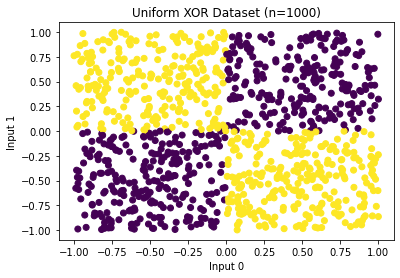

In [3]:
plt.scatter(inputs[0], inputs[1], c=outputs)
plt.title("Uniform XOR Dataset (n=1000)")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

## Train large network

Now, train a fully connected neural network on this dataset with ~5,000 free parameters for 100 epochs.

In [4]:
num_observations = inputs.shape[1]
num_inputs = inputs.shape[0]
num_outputs = outputs.shape[0]

hidden_layer_width=50
num_hidden_layers=3

layers = [ tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu, input_shape=(num_inputs,))]
for i in range(num_hidden_layers-1):
    layers.append( tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu))
layers.append(tf.keras.layers.Dense(num_outputs, activation=tf.nn.relu))

model = tf.keras.Sequential(layers)

model.compile(
# loss='binary_crossentropy', # binary classification
# loss='categorical_crossentropy', # categorical classification (one hot)
loss='mean_squared_error',  # regression
optimizer=tf.keras.optimizers.Adam(0.001),
# optimizer='rmsprop',
# metrics=['accuracy'],
)

model.fit(
    x=inputs.T,
    y=outputs.T,
    shuffle=True,
    validation_split=.2,
    epochs=100,
    batch_size=128,
    )

model.summary()

Epoch 1/100


2022-07-05 10:01:06.631009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 0s 21ms/step - loss: 0.4785 - val_loss: 0.4349
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 0.3736 - val_loss: 0.3004
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 0.2508 - val_loss: 0.2167
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.1820 - val_loss: 0.1591
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1322 - val_loss: 0.1161
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0983 - val_loss: 0.0930
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0802 - val_loss: 0.0781
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0710 - val_loss: 0.0713
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0667 - val_loss: 0.0672
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0629 - val_loss: 0.0633
Epoch 11/100
7/7 [======================

313/313 [==============================] - 0s 736us/step


/var/folders/3g/8436y4yj1r9367dvt15y6jqcdx0hcv/T/ipykernel_2283/2471555115.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy,z, label="Prediction (large)")


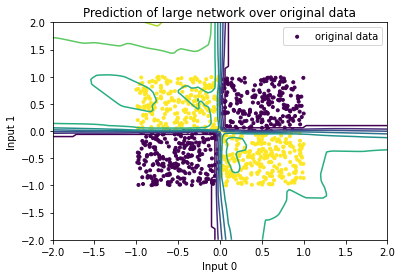

In [5]:
y_pred = model.predict(inputs.T)

X = np.linspace(-2,2,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
 
plt.contour(xx,yy,z, label="Prediction (large)")
plt.scatter(inputs[0], inputs[1], c=outputs[0], marker=".", label="original data")
plt.legend()
plt.title("Prediction of large network over original data")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

With 20,601 trainable parameters, we are able to get a pretty good decision boundary at least for the in-sample region (-1,1). However, we can see that the network has not learned the exact XOR rule, as evidenced by some unnecessary level curves at the edges of the decision boundary. One may ask the question, does this network faithfully compute XOR throughout the entire $\mathbb{R}^2$ plane?

## Distill large network into smaller network

In [6]:
## Import distiller class from example in Tensorflow documentation
from lib.knowledge_distillation import Distiller

In [18]:
num_observations = inputs.shape[1]
num_inputs = inputs.shape[0]
num_outputs = outputs.shape[0]

hidden_layer_width=10
num_hidden_layers=3

layers = [ tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu, input_shape=(num_inputs,))]
for i in range(num_hidden_layers-1):
    layers.append( tf.keras.layers.Dense(hidden_layer_width, activation=tf.nn.relu))
layers.append(tf.keras.layers.Dense(num_outputs, activation=tf.nn.relu))

student_model = tf.keras.Sequential(layers)

distiller = Distiller(student=student_model, teacher=model)

distiller.compile(
    student_loss_fn=tf.keras.losses.MeanSquaredError(),  # regression
    distillation_loss_fn=tf.keras.losses.KLDivergence(),  # regression
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    alpha=0.1,
    temperature=10
)

distiller.fit(
    x=inputs.T,
    y=outputs.T,
    # shuffle=True,
    # validation_split=.2,
    epochs=100,
    # batch_size=128,
    )


Epoch 1/100
32/32 [==============================] - 1s 1ms/step - mean_squared_error: 0.3950 - student_loss: 0.3910 - distillation_loss: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - mean_squared_error: 0.2601 - student_loss: 0.2564 - distillation_loss: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - mean_squared_error: 0.1968 - student_loss: 0.1943 - distillation_loss: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - mean_squared_error: 0.1581 - student_loss: 0.1574 - distillation_loss: 0.0000e+00
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - mean_squared_error: 0.1281 - student_loss: 0.1261 - distillation_loss: 0.0000e+00
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - mean_squared_error: 0.1039 - student_loss: 0.1038 - distillation_loss: 0.0000e+00
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - mean_squared_error: 0.0875 - student_lo

In [19]:
student_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                30        
                                                                 
 dense_25 (Dense)            (None, 10)                110       
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 0s 786us/step


/var/folders/3g/8436y4yj1r9367dvt15y6jqcdx0hcv/T/ipykernel_2283/1774186602.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy,z, label="Prediction (large)")


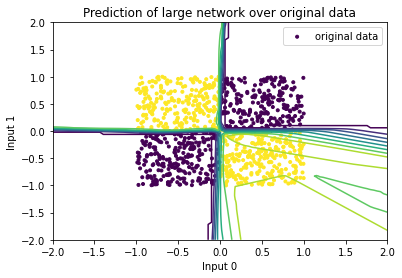

In [22]:
X = np.linspace(-2,2,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = student_model.predict(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
 
plt.contour(xx,yy,z, label="Prediction (large)")
plt.scatter(inputs[0], inputs[1], c=outputs[0], marker=".", label="original data")
plt.legend()
plt.title("Prediction of large network over original data")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

# Verify both networks

Assert that the decision is correct inside each quadrant (with some padding)?

Constant Padding
- Q1: Input 0 > 0.5 and Input 1 > 0.5 => Output 0 == False
- Q2: Input 0 > 0.5 and Input 1 < -0.5 => Output 0 == True
- Q3: Input 0 < -0.5 and Input 1 < -0.5 => Output 0 == False
- Q4: Input 0 > 0.5 and Input 1 < -0.5 => Output 0 == True

Proportional Padding
- Q1: Input 0 > 1/1000 * Input 1 and Input 1 > 1/1000 * Input 0 => Output 0 == False
- Q2: Input 0 > 1/1000 * Input 1 and Input 1 < -1/1000 * Input 0 == True
- Q3: Input 0 < -1/1000 * Input 1 and Input 1 < -1/1000 * Input 0 == False
- Q4: Input 0 > 1/1000 * Input 1 and Input 1 < -1/1000 * Input 0 == True

## Data Driven Method
Ensure that every data point in the dataset satisfying the preconditions evaluate to the correct output.


In [40]:
padding = 0.1

# This property list is of the format:
# (Name of property, region of input for which it must apply, output value
properties = (
    ("Q1", inputs[:,(inputs[0] > padding) & (inputs[1] > padding)], False),
    ("Q2", inputs[:,(inputs[0] < -padding) & (inputs[1] > padding)], True),
    ("Q3", inputs[:,(inputs[0] < -padding) & (inputs[1] < -padding)], False),
    ("Q4", inputs[:,(inputs[0] > padding) & (inputs[1] < -padding)], True),
)

for model_name, the_model in [("student", student_model), ("teacher", model)]:
    print(f"Inspecting {model_name}")
    for property_name, property_data, property_output in properties:
        prediction = the_model.predict(property_data.T)
        assert (np.abs(prediction - property_output) < 0.5).all() , f"{property_name} failed"
        print(f"Model {model_name}, {property_name} property passed!")

Inspecting student
6/6 [==============================] - 0s 1ms/step
Model student, Q1 property passed!
6/6 [==============================] - 0s 957us/step
Model student, Q2 property passed!
7/7 [==============================] - 0s 979us/step
Model student, Q3 property passed!
7/7 [==============================] - 0s 2ms/step
Model student, Q4 property passed!
Inspecting teacher
6/6 [==============================] - 0s 1ms/step
Model teacher, Q1 property passed!
6/6 [==============================] - 0s 1ms/step
Model teacher, Q2 property passed!
7/7 [==============================] - 0s 1ms/step
Model teacher, Q3 property passed!
7/7 [==============================] - 0s 1ms/step
Model teacher, Q4 property passed!


## Probabilistic Method
Ensure that a random samples from within the precondition produce the correct output.

In [57]:
padding = 0.1
max_distance = 100.0
samples = 1000

# This property list is of the format:
# (Name of property, region of input for which it must apply, output value
properties = [
    ("Q1", np.array([np.random.uniform(padding, max_distance, samples), np.random.uniform(padding,max_distance,samples)]), False)
]

for model_name, the_model in [("student", student_model), ("teacher", model)]:
    print(f"Inspecting {model_name}")
    for property_name, property_data, property_output in properties:
        prediction = the_model.predict(property_data.T)
        errors = (np.abs(prediction - property_output) < 0.5)
        if not errors.all():
            print(f"{property_name} failed")
            print(property_data[:,errors.flatten()==False])
            continue
        print(f"Model {model_name}, {property_name} property passed!")

Inspecting student
32/32 [==============================] - 0s 796us/step
Q1 failed
[[ 0.53292078  1.76950849  0.82499336  1.37367448  1.05514855  1.42882084
   1.69659132  2.87269589  1.99060805  3.33564178  2.31080263  1.45309428
   1.13944891  0.51757869  3.28930136  2.40207042]
 [55.90251679 42.85418787 51.81498445 79.44840646 34.89693923 70.79983384
  90.39959868 72.76626683 97.6232102  81.81426257 85.41016479 49.07111696
  39.54028618 40.42689435 92.49500284 94.26453293]]
Inspecting teacher
32/32 [==============================] - 0s 787us/step
Q1 failed
[[ 0.53292078]
 [55.90251679]]


## Analytic Method
Ensure that all points within the precondition produce the correct output.

### Using abstraction
### Complete